<a href="https://colab.research.google.com/github/vhrique/ELF/blob/main/5_1_Image_Germination_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!cp -r /content/drive/MyDrive/Trabalho/Silex/Serviços/Nacre/Outros/Seed-X\ Project/Data/dataset_germination_20250323 /content/dataset_germination
!sync

In [ ]:
!pip install pytorch_lightning easycm > package.txt

In [ ]:
import os

import seaborn as sns
import pandas as pd
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.optim as optim
import timm

from collections import Counter
from PIL import Image
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchvision import transforms
from tqdm import tqdm

In [ ]:
class SeedlingClassifier(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = timm.create_model(
            'convnextv2_atto',
            pretrained=True,
            num_classes=3
        )
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        # log training loss
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        # compute accuracy
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val_acc", acc, on_step=False, on_epoch=True, prog_bar=True)
        return {'val_loss': loss, 'val_acc': acc}

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        # Log test metrics so that they appear in TensorBoard and the progress bar
        self.log("test_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("test_acc", acc, on_step=False, on_epoch=True, prog_bar=True)
        return {'test_loss': loss, 'test_acc': acc}

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-4)
        return optimizer

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, df: pd.DataFrame, transform=None):
        """
        Args:
            df (pd.DataFrame): DataFrame with columns 'filename' and 'class'
            img_dir (str): Directory with all the images.
            transform: Optional transform to be applied on an image.
        """
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.classes = {'NG': 0, 'S': 1, 'G': 2}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get the filename and label from the DataFrame
        row = self.df.iloc[idx]
        basename = os.path.split(row['filename'])[1]
        filename = os.path.join('/content/dataset_germination/images', basename)
        image = Image.open(filename).convert("RGB")
        label = self.classes[row['germination']]
        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandAugment(num_ops=2, magnitude=9),  # adjust parameters as needed
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

# Validation and test transforms (no augmentation)
transform_val_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

In [ ]:
data_path = '/content/drive/MyDrive/Trabalho/Silex/Serviços/Nacre/Outros/Seed-X Project/Data/dataset_germination_20250323'

In [ ]:
df = pd.read_csv(os.path.join(data_path, 'index.csv'))
df = df.query('germination == "G" or germination == "S" or germination == "NG"')

val_batch = '7291'
test_batch = '7356'
train_df = df.query(f'batch != {val_batch} and batch != {test_batch}')
val_df = df.query(f'batch == {val_batch}')
test_df = df.query(f'batch == {test_batch}')

label_counts = Counter(train_df.germination.tolist())
total_samples = len(train_df)
cluster_weights = {label: total_samples / count for label, count in label_counts.items()}
sample_weights = [cluster_weights[label] for label in train_df.germination.tolist()]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

train_dataset = CustomImageDataset(train_df, transform_train)
val_dataset = CustomImageDataset(val_df, transform_val_test)
test_dataset = CustomImageDataset(test_df, transform_val_test)

train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=8, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=8, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=8, pin_memory=True)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
model_path = os.path.join(data_path, 'model_20250408')
logs_path = os.path.join(model_path, 'logs')

checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',           # metric to monitor
    dirpath=model_path,           # directory to save checkpoints
    filename='best-checkpoint',   # filename template
    save_top_k=1,                 # only save the best model (k=1)
    mode='min'                    # mode 'min' because we want to minimize validation loss
)

logger = TensorBoardLogger(logs_path, name="convnextv2_atto_classifier")

model = SeedlingClassifier()

trainer = pl.Trainer(max_epochs=50, logger=logger, callbacks=[checkpoint_callback])

trainer.fit(model, train_loader, val_loader)

In [ ]:
model = SeedlingClassifier.load_from_checkpoint(os.path.join(model_path, 'best-checkpoint.ckpt'))
model.eval();

In [ ]:
full_dataset = CustomImageDataset(df, transform_val_test)

labels = []
predictions = []
for i, data in enumerate(full_dataset):
    image, label = data
    with torch.no_grad():
        logits = model(image.to(model.device).unsqueeze(0)).squeeze(0)
        pred_class = torch.argmax(logits, dim=0).item()
        predictions.append(pred_class)
        labels.append(label)

images = df.filename.tolist()

pd.DataFrame({
    'filename': images,
    'label': labels,
    'predictions': predictions
}).to_csv(os.path.join(model_path, 'predictions.csv'), index=False)

In [ ]:
df = pd.read_csv(os.path.join(model_path, 'predictions.csv'))
df['validation'] = [str(val_batch) in fn for fn in df.filename]
df['test'] = [str(test_batch) in fn for fn in df.filename]

              precision    recall  f1-score   support

          NG       0.98      0.98      0.98      1862
           S       0.79      0.99      0.88       500
           G       0.99      0.96      0.98      3980

    accuracy                           0.97      6342
   macro avg       0.92      0.98      0.95      6342
weighted avg       0.97      0.97      0.97      6342



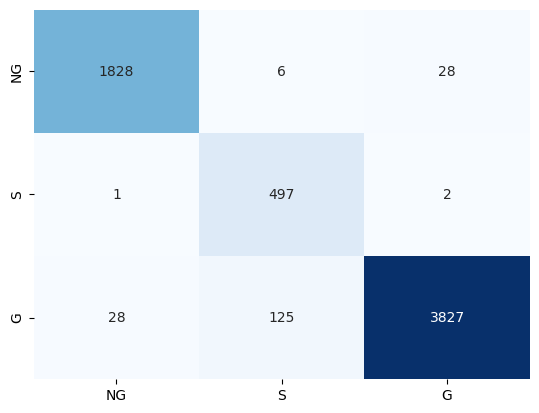

In [ ]:
df_train = df.query('validation == False and test == False')

labels = ['NG', 'S', 'G']
print(classification_report(df_train.label, df_train.predictions, target_names=labels))

cm = confusion_matrix(df_train.label, df_train.predictions)
df_cm = pd.DataFrame(cm, labels, labels)
sns.heatmap(df_cm, cmap='Blues', cbar=False, annot=True, fmt='d');

              precision    recall  f1-score   support

          NG       0.99      0.95      0.97       226
           S       0.63      0.73      0.68        52
           G       0.95      0.96      0.95       406

    accuracy                           0.94       684
   macro avg       0.86      0.88      0.87       684
weighted avg       0.94      0.94      0.94       684



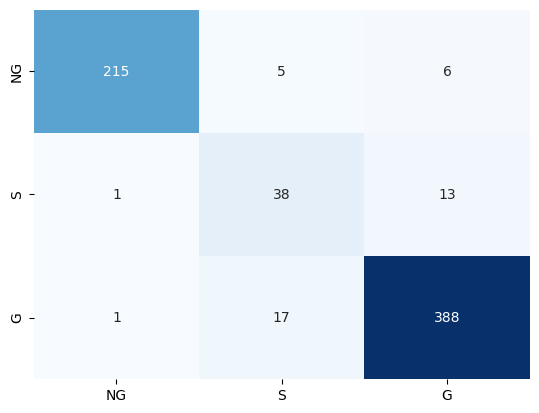

In [ ]:
df_val = df.query('validation == True')

labels = ['NG', 'S', 'G']
print(classification_report(df_val.label, df_val.predictions, target_names=labels))

cm = confusion_matrix(df_val.label, df_val.predictions)
df_cm = pd.DataFrame(cm, labels, labels)
sns.heatmap(df_cm, cmap='Blues', cbar=False, annot=True, fmt='d');

              precision    recall  f1-score   support

          NG       0.94      0.99      0.96       143
           S       0.53      0.76      0.63        74
           G       0.96      0.89      0.92       464

    accuracy                           0.89       681
   macro avg       0.81      0.88      0.84       681
weighted avg       0.91      0.89      0.90       681



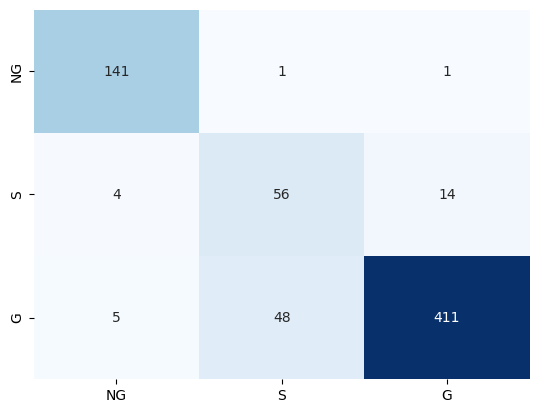

In [ ]:
df_test = df.query('test == True')

labels = ['NG', 'S', 'G']
print(classification_report(df_test.label, df_test.predictions, target_names=labels))

cm = confusion_matrix(df_test.label, df_test.predictions)
df_cm = pd.DataFrame(cm, labels, labels)
sns.heatmap(df_cm, cmap='Blues', cbar=False, annot=True, fmt='d');

In [ ]:
from google.colab.runtime import unassign
unassign()